# FirstConvNN MNISTdataset

A first example about Convolutional NNs, using the well-known MNISt dataset.

## IMPORTING LIBRARIES

We import the classic things, in particular, `keras` and its classic layers.

In addition, we also import the `Conv2D` layer: this is a Convolutional layer on bi-dimensional strustires, i.e. images. (There is also the conv layer for monodimensional sequences).

In [1]:
from tensorflow.keras.layers import Input, Dense, Flatten  # Classic layers
from tensorflow.keras.layers import Conv2D  # Convolutional layers

from tensorflow.keras.models import Model  

from tensorflow.keras.datasets import mnist  # MNIST dataset

import numpy 

## LOAD THE DATASET

Let us load the mnist dataset. It is already splitted into train-test.

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [4]:
print('There are {} samples in the training set'.format(x_train.shape[0]))
print('There are {} samples in the test set'.format(x_test.shape[0]))

There are 60000 samples in the training set
There are 10000 samples in the test set


## PRE-PROCESSING

Some pre-processing operations must be performed.

### 1) Normalization of the input data `x`

The values in `x` (both `x_train` and `x_test`) are in the range $[0,255]$. We want to normalize these values into the range $[0,1]$. Remapping the values into the range $[0,1]$.

We do this normalization with the MinMaxScaling technique..

In [5]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

### 2) Adding the channels dimension to the input data `x`

Flattening the input images in `x` is not needed anymore, since we are working with convolutional layers: they expect bi-dimensional instances. They expect images (i.e. matrices) as input.

*Dense layers: they expect flat structures in input. Conv layers: they expect 2D structures in input.*

**Channels**

Actually, the Conv layers expect an input with $3$ dimensions: the $2$ spatial dimensions $w,h$ and the channels dimension $c$.

The chanels can be thought as different images, with same spatial dimensions $w,h$, which are different views about the same content. 

In the input layer, different channels are about the different colors: $3$ channels, one for the color red, one for the color green, one for the color blue. 

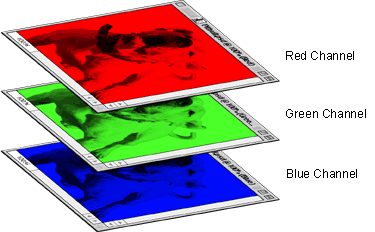

Instead, in a convolutional layer, the different channels represent different feature maps extracted by different kernels from the same input image. (A feature map is an image which is obtained from an input image by applying a certain kernel. Basically, a feature map indicates if and where the pattern corresponding to the kernel has been found in the image).

**Adding the channels dimension to the input image *(If the images were colored images, this operation would not been needed)***

In the MNISt dataset `x`, the images are grey-scale images. So, they have a single channel. Single image. 

Basically, the instances in `x` don't have the channel dimension. Each instance is a single image, a single channel, about the grey intensities.

This both the training `x_train` and the test `x_test`.

We can check that.

In [6]:
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


As we can see, the training `x_test` contains $60000$ instances: each instance is an image $28*28$. Each instance is a single image, single channel. Each instance has only two dimensions, which are the spatial dimensions. No channel dimensions.

The same in the test `x_test`.

So, we need to make the instances in `x` compliant with the Conv layers. We need to add the channels dimension: each instance must have $3$ dimensions. In this case, the value value of the channels dimension is $1$ (only $1$ channel). 

So, let's reshape the training `x_train`.

For doing this transformation, let's first of all extract the current dimensions of `x_train`, and then we reshape it, adding the channels dimension. 

In [7]:
# Extracting the current dimensions of `x_train`
# 'n_train': number of instances
# 'w','h': spatial dimensions of each instance. 'w' is the sidth, 'h' is the height. Basically, size of the image.
(n_train, w, h) = x_train.shape

# Reshaping `x_train`, adding the channels dimension (equal to 1)
x_train = x_train.reshape(n_train, w, h, 1)

We do the same thing for `x_test`.

In [8]:
# Extracting the current dimensions of `x_test`
# 'n_test': number of instances
# 'w','h': spatial dimensions of each instance. 'w' is the sidth, 'h' is the height. Basically, size of the image.
(n_test, w, h) = x_test.shape

# Reshaping `n_test`, adding the channels dimension (equal to 1)
x_test = x_test.reshape(n_test, w, h, 1)

Now, each instance in `x` has $3$ dimensions: the $2$ spatial dimensions ($w,h$) and the channels dimension ($c$).

In [9]:
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


### 3) Transforming `y` into the categorical distribution

Actually, we will use the `sparse_categorical_crossentropy` instead of the `categorical_crossentropy`. Therefore, we dont' need to transform the target vector `y`, neither the training `y_train` nor the test `y_test`. We can use directly the integer labels as they are.

## GENERAL DESCRIPTION OF A  CONVOLUTIONAL NN

Let's generally describe a Convolutional NN.

### Convolutional layer

Let's briefly describe a convolutional layer.

**Input**

A convolutional layer takes an input with three dimensions: the spatial dimensions $w_{in},h_{in}$ (i.e. width and height of the input) and the channels dimension $c_{in}$ (i.e. number of channels of the input, which are different images with the same spatial dimensions $w_{in},h_{in}$).<img src=attachment:image-2.png alt="drawing" width="300"/>
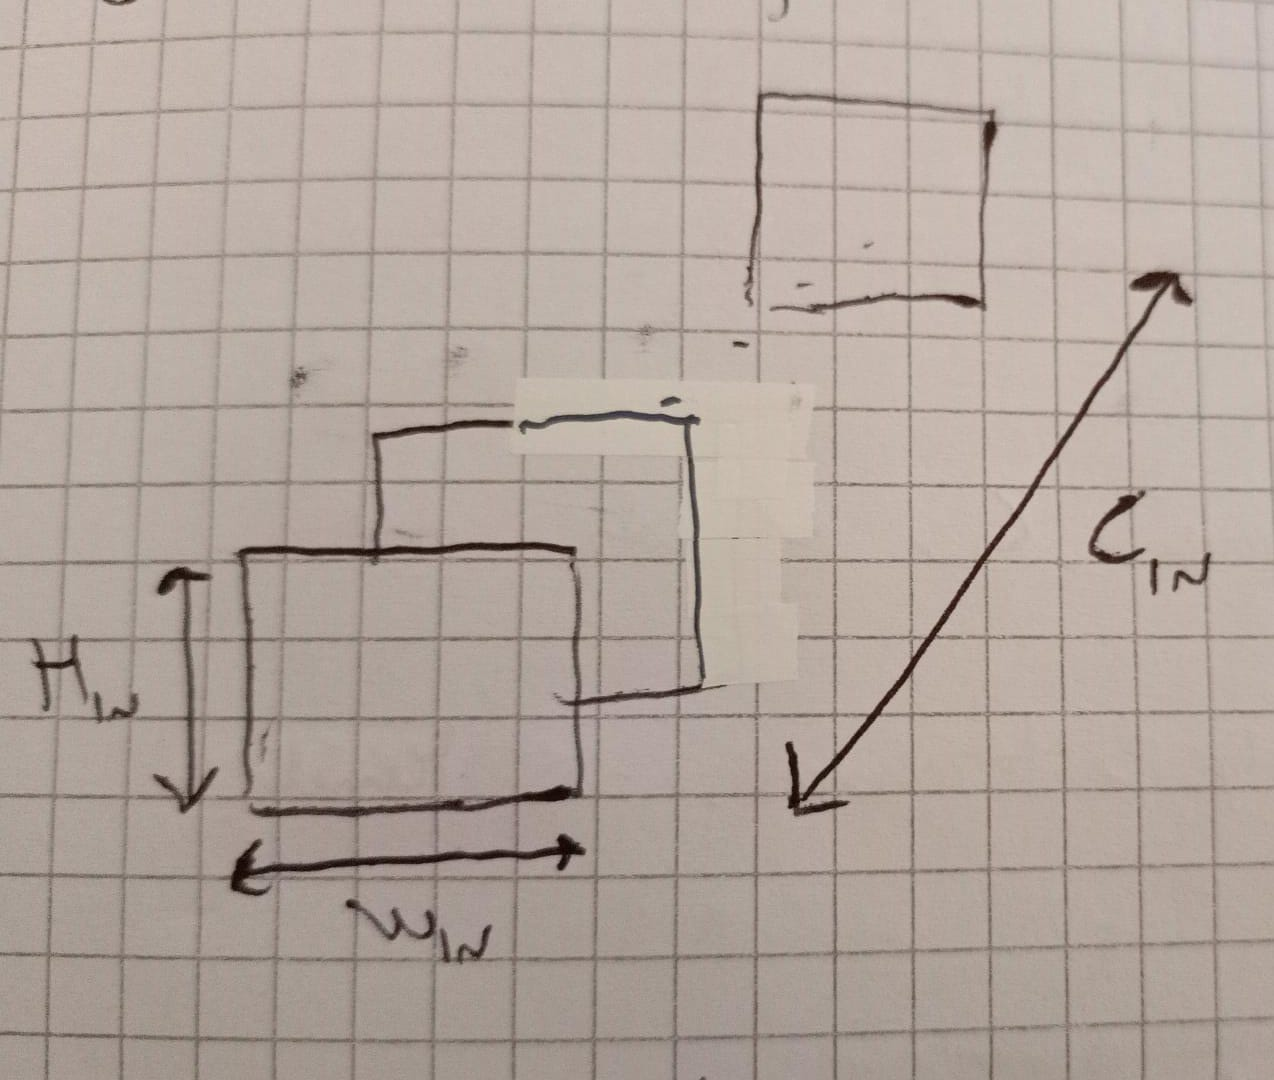

**Kernels**

A layer has a certain number of different kernels: $c_{out}$ different kernels. 

Each kernel has two spatial dimensions: the two spatial dimensions $k_1,k_2$ (width and heigth), which are equal among all the kernels of the layer (they are fixed on the layer). 

Each kernel has also the channels dimension. The channels dimension of each kernel is equal to the channels dimension of the input of that layer: $c_{in}$. 

So, each kernel has $3$ dimensions: spatial dimensions $k_1,k_2$ and channels dimensions $c_{in}$.

Basically, each kernel  contains $k_1*k_2*c_{in}$ values, which are parameters. They are the weights that must be learnt during training.

(We can think of a 3-dimensional kernel $k_1*k_2*c_{in}$ as a collection of $c_{in}$ bi-dimensional kernels, with size $k_1,k_2$. Sequence of $c_{in}$ bi-dimensional kernels, with size $k_1,k_2$.)

On the whole, there are $c_{out}$ kernels. Each kernel has the same number of parameters: $k_1*k_2*c_{in}$. Therefore, we have in total $c_{out}*k_1*k_2*c_{in}$ weigths in that layer. (Actually, $c_{out}*k_1*k_2*c_{in} + c_{out}$, because each kernel has also one bias).<img src=attachment:image.png alt="drawing" width="300"/>
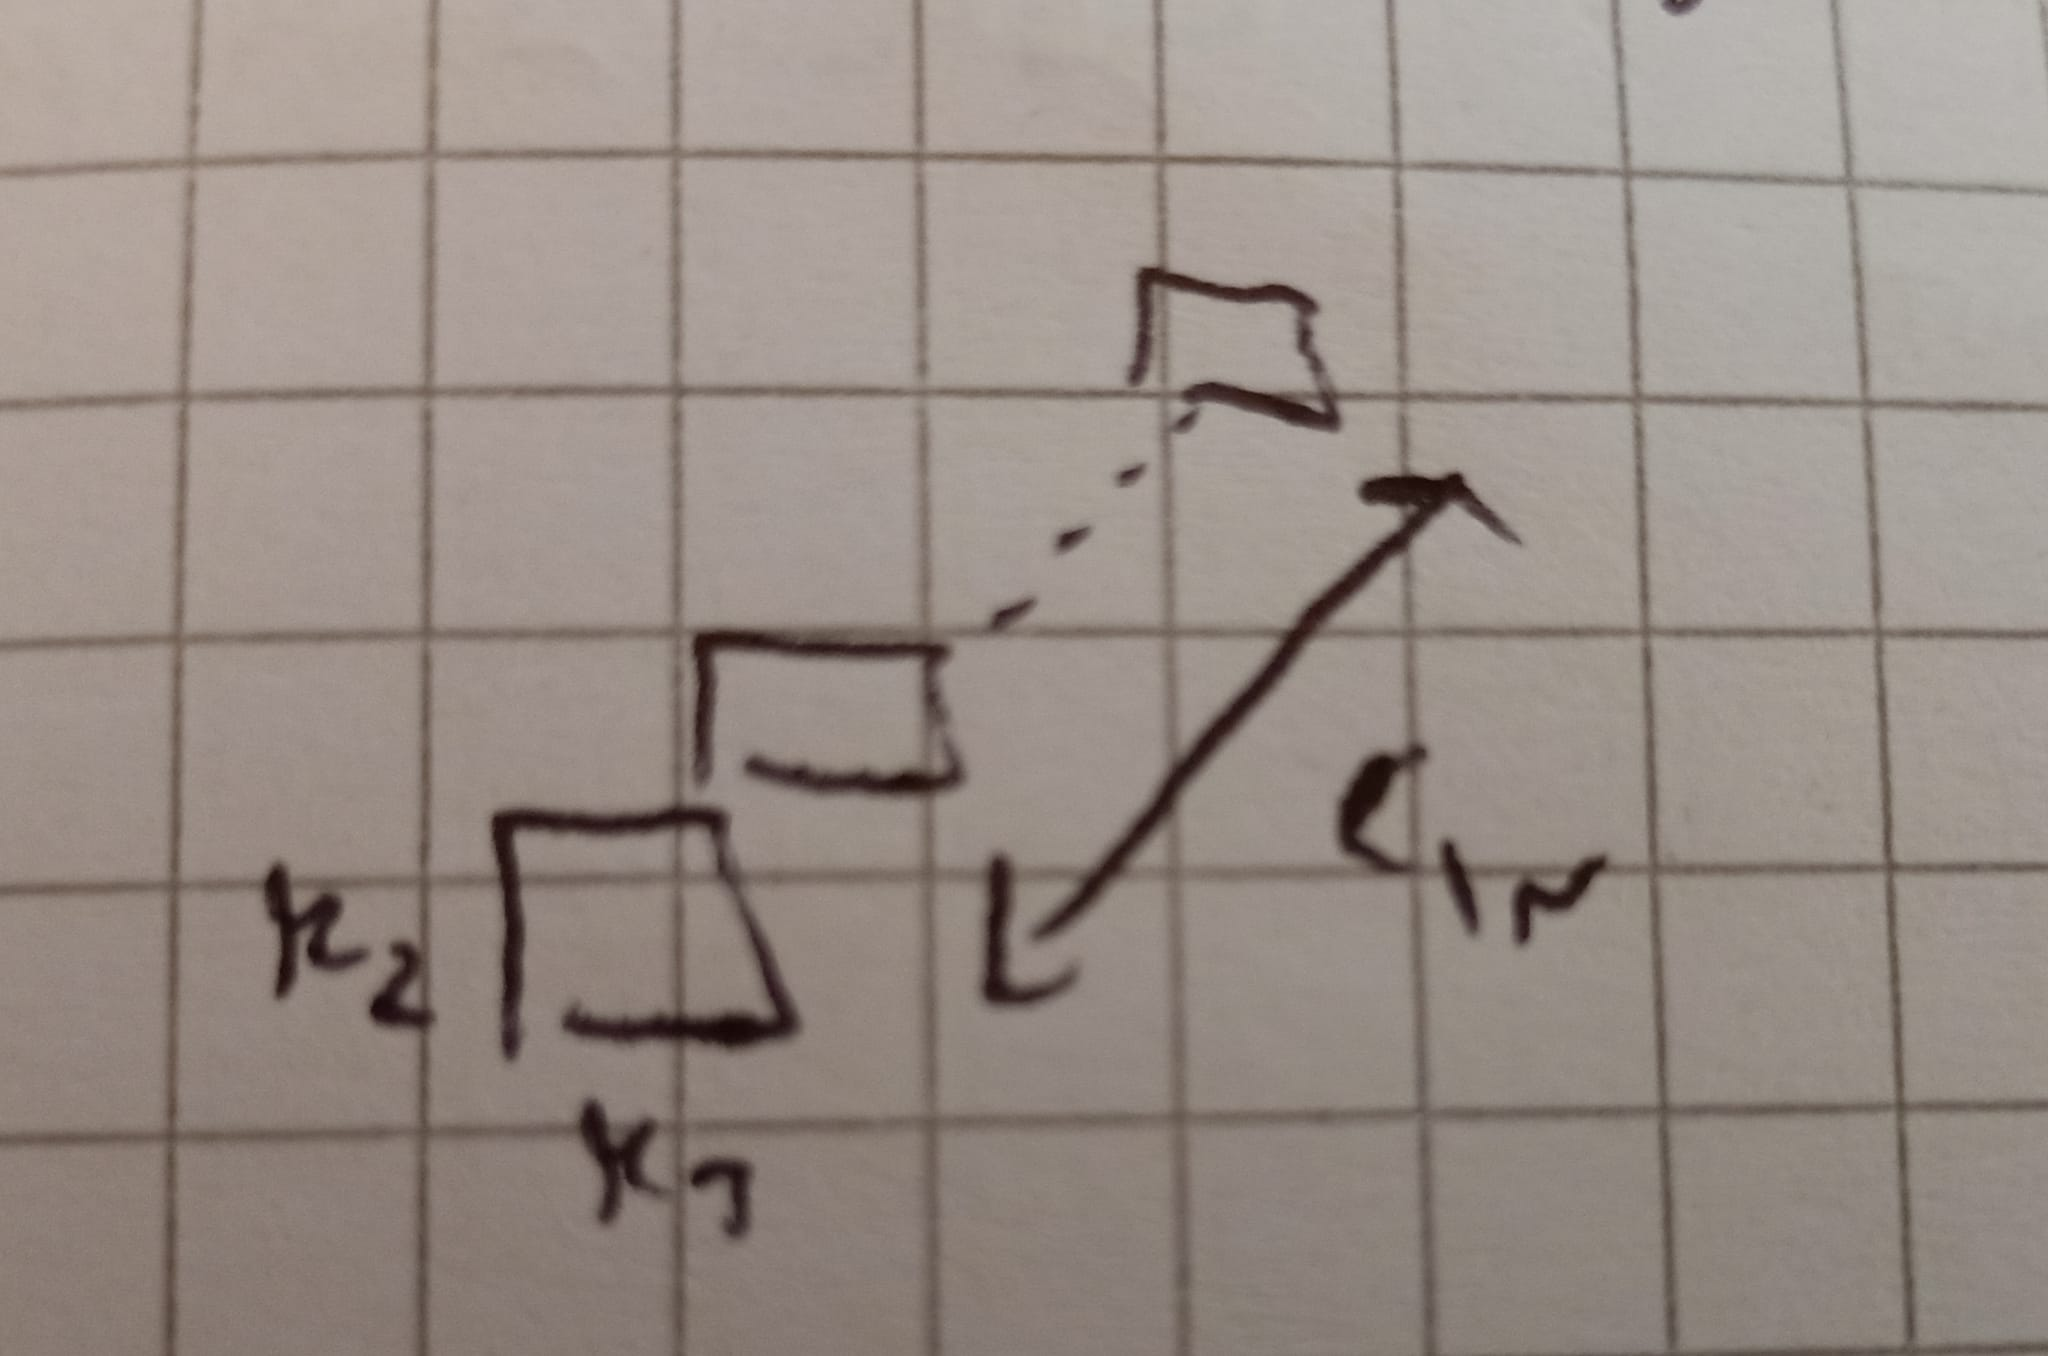

**Output**

Each kernel produces a different image, called feature map, which enlights where the pattern corresponding to that kernel has been found in the input of the layer.

Since there are $c_{out}$ kernels, the layer produces in output $c_{out}$ feature maps (i.e. images). These are the output channels. $c_{out}$ output channels. 

All these channels have the same spatial dimensions, which are $w_{out},h_{out}$ (i.e. width and height of each output image/feature map).

So, on the whole, the output of the layer has $3$ dimensions: two spatial dimensions $w_{out},h_{out}$ and the channels dimensions $c_{out}$.<img src=attachment:image.png alt="drawing" width="300"/>
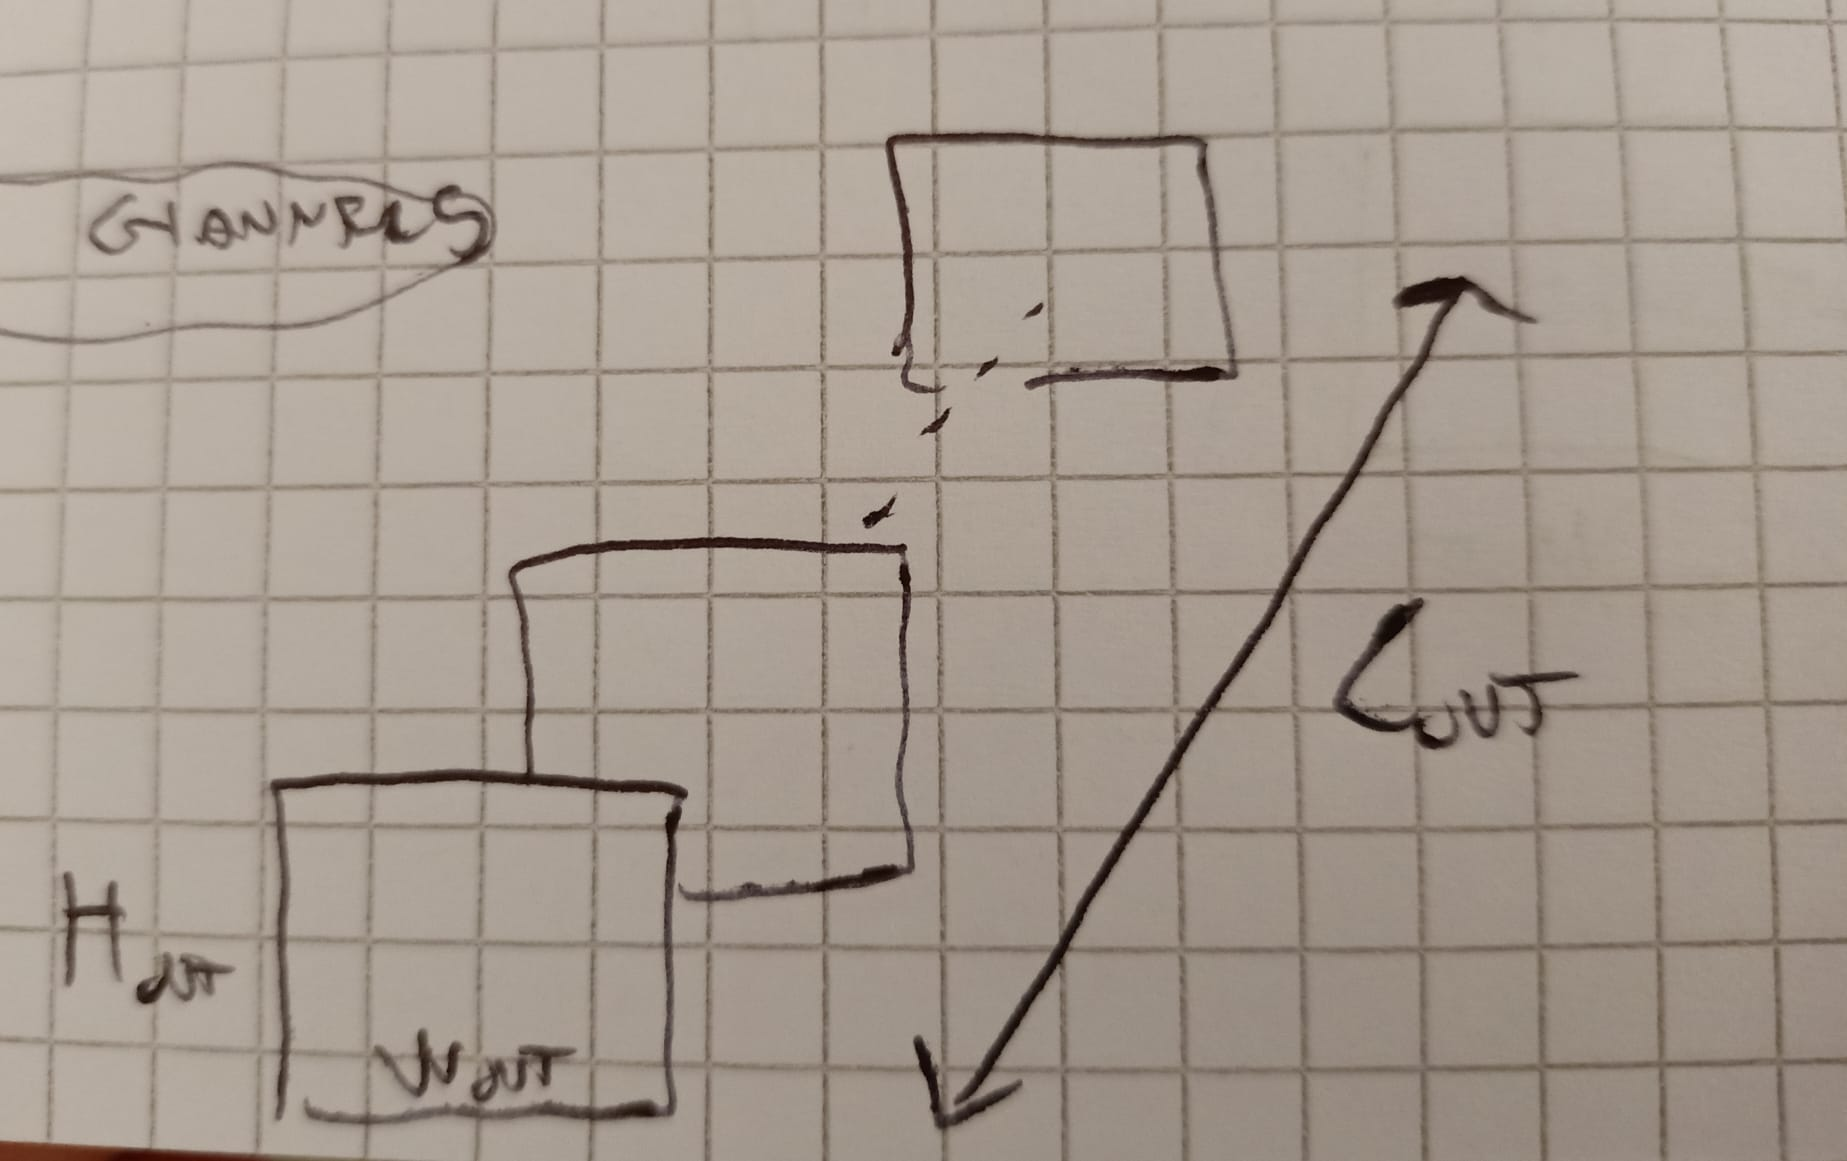

### Insights about the convolutional layer 

**Application of one kernel**

Input $w_{in}, h_{in}, c_{in}$. Let's focus on a single kernel $k_1, k_2, c_{in}$. How the kernel is applied on the input, producing the corresponding output feature map with spatial dimensions $w_{out}, h_{out}$?

For each pixel/position of the output image, the kernel is applied independently (i.e. $w_{out}, h_{out}$ total application of that kernel).

Fixed pixel/position $p$. Let's focus on a certain input channel (certain input image). Let's focus on the $i$-th input channel. The $i$-th bi-dimensional kernel $k1, k2$ is applied on the corresponding $i$-th bi-dimensional input channel $w_{in}, h_{in}$. 

Basically:
- the neighborood of positions of the pixel $p$ are taken (neighboroood with the same structure and size of the kernel, centered in the given pixel $p$);
- the values of these pixels are taken;
- these values are multiplied with the corresponding weigths in the bi-dimensional kernel;
- the sum of all these values is performed.

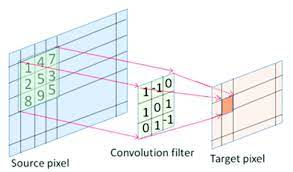

This is performed independently for each input channel. So, from each input channel, we get a value: $c_{in}$ different values. All these values are summed together, into a single value.

This single value is the value of the pixeò $p$ in the output image.

This operation is performed for each pixel $p$ in the output feature map, which has size $w_{out},h_{out}$.

Example with only $2$ channels.<img src=attachment:image.png alt="drawing" width="400"/>

In general <img src=attachment:image-2.png alt="drawing" width="400"/>
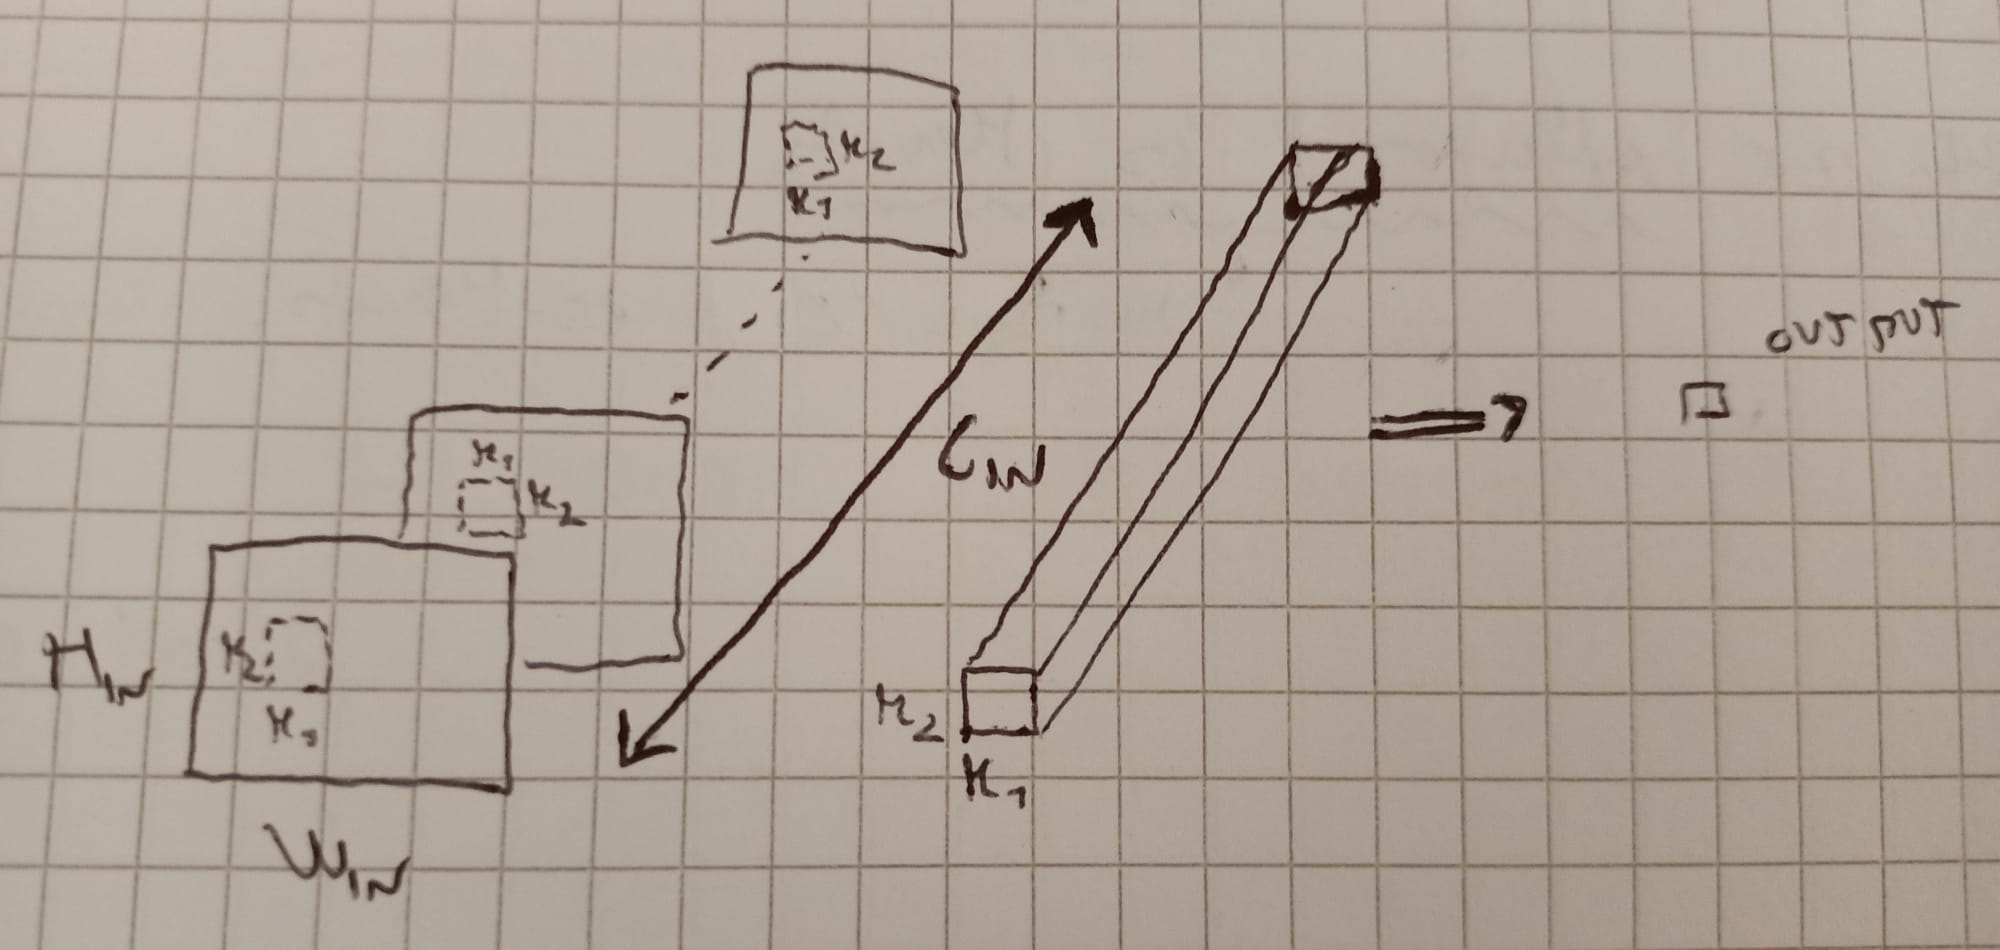
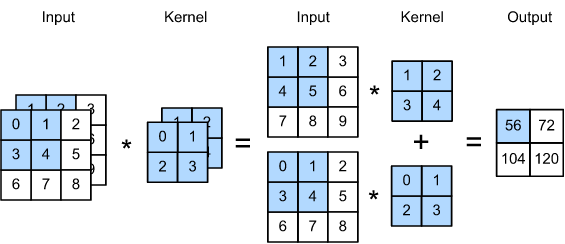

*Basically, the 3-dimensional kernel is applied both across the spatial dimensions of the input and across the channels dimension of the input, producing a single output image.*

**Bias and activation function**

Actually, each kernel has also a bias. Basically, the bias is a parameter of the kernel, which is sum to each pixel value of the output image/feature map.

In addition, the user can specify that the Convolutional layer has a certain activation function. In this case, for each kernel of the layer, that activation function is applied to each pixel value of the output image/feature map.

**Main hyperparameters of the convolutional layer**

The main hyperparameters of a convolutional layer are:
- Number of kernels, i.e. output channels dimension $c_{out}$;
- Kernel size, i.e. kernel spatial dimensions $k_1,k_2$;
- Padding, in both dimensions, i.e. $P_1,P_2$ (they define the amount of additional fake pixels are added into the input spatial dimensions $w_{in},h_{in}$);
- Stride, in both dimensions, i.e. $S_1,S_2$ (they define the step of the application of the kernel across the spatial dimensions of the input $w_{in},h_{in}$;
- Activation function.

**Spatial dimensions of the output**

How the spatial dimensions of the output $w_{out},h_{out}$ are determined? They are determined by the kernel size, padding and stride, with the following formula.

$w_{out} = \frac{w_{in}+P_1-k_1}{S_1} + 1$

The same for the other spatial dimensions.

**Two main padding modes**

The two main padding modes are the following.
- **'same'**. It is applied enough padding in order to be able to apply tke kernel also in the borders (basically $P_1=k_1, P_2=k_2$). In this case, the formula of the spatial dimensions of the output becomes $w_{out} = \frac{w_{in}}{S_1} + 1$.
- **'valid'**. No padding is perfomed (basically $P_1=0, P_2=0$). . In this case, the formula of the spatial dimensions of the output becomes $w_{out} = \frac{w_{in}-k_1}{S_1} + 1$.

**Role of the stride**

The stride is important, beacuse it is able to reduce the spatial dimensions of the input of the layer. In other words, thanks to the stride spatial dimensions of the output can be smaller the than spatial dimensions of the input. 

Unitary stride (i.e. $S_1=1, S_2=1$): the spatial dimensions of the input are not reduced.

Non-unitary stride (i.e. $S_1>1, S_2>1$): the spatial dimensions of the input are reduced.

### General structure of a Conv NN

A Conv NN has the following general structure.

**1 Input layer**. 

Each input instance has three dimensions: the spatial dimensions $w,h$ (i.e. width and height) and the channels dimension $c$ (i.e. number of channels, which are different images with the same spatial dimensions $w,h$.  

**2 Convolutional part: a sequence of convolutional layers.**

Sequence of convolutional layers. Each convolutional layer has:
- input with dimensions $w_{in}, h_{in}, c_{in}$;
- $c_{out}$ kernels, each with dimensions $k_1, k_2, c_{in}$;
- output with dimension $w_{out}, h_{out}, c_{out}$.

**The aim of the convolutional part of the NN is to extract the relevant features from the input dataset `x_train`. The aim is to understand the useful patterns from the input images in `x_train`. With 'useful' we mean useful for the classification task.**

**3 Flattening**

Since now, in the input layer and in the convolutional part, the input of each layer has a bi-dimensional structure. It is an image: spatial dimensions $w,h$. Actually, it has an even more complex structure. It has $3$ dimensions: the spatial dimensions $w,h$ and the channels dimension $c$.

However, the following part of the NN will be a Dense part, i.e. a sequence of Dense layers. This part works with a flat input. It works with a non-structured input: completely flat input. Only one dimension basically.

This means that, before starting the Dense part of the NN, the input must be flattened. The instance, processed by the NN, must be flattened: from $3$ dimensions to $1$ dimension.

For doing this, the Flatten layer is used.

Let $w_{in},h_{in},c_{in}$ the dimensions of the input of the FLat layer (i.e. the dimensions of the output of the last Convolutional layer). Then, the output of the Flat layer will have dimensions $w_{in}*h_{in}*c_{in}$: only one flat dimension.

**4 Dense part**

This is the last part of the NN. It is a sequence of Dense layers.

Each Dense layer has $D_{in}$ number of inputs and $D_{out}$ number of outputs. There are $D_{in}*D_{out}$ number of parameters (actually, $D_{in}*D_{out}+D_{out}$, due to the bias of each output neuron).

**The aim of the dense part of the NN is to exploit the features extracted from the convolutional part for classifying the instances in `x_train`. The Dense part uses the features for the classification purpose.** 

The last Dense layer is the output layer of the NN. It has as many neurons as the different possible classes. It returns the categorical distribution over the classes. The activation function is the softmax (or sigmoid if binary classification).

### Insights about the structure of a Conv NN

**Depth of the Conv part and Dense part**

So, as described, the Conv part and the Dense part have different purposes: the first has to extract the features, the second has to exploit the features for classification.

These two parts have also a very different depths. They have a very different number of layers.

The Conv part is typically very deep. A lot of convolutional layers.

The Dense part instead is typically very shallow. Few dense layers.

**Conv part: decreasing of the spatial dimensions and increasing of the channels dimensions**

Typically, the Conv part of the NN follows a certain approach. Which consists in gradually decreasing the spatial dimensions $w,h$ and increasing the channels dimension $c$.

So, typically, each Conv layer has the following properties.
- The output spatial dimensions $w_{out},h_{out}$ are smaller than the input spatial dimensions $w_{in},h_{in}$. This is obtained by fixing a non-unitary Stride $S_1,S_2$.
- The output channels dimension $c_{out}$ is bigger than the input channels dimension $c_{in}$. This is obtained by simply fixing a number of kernels $c_{out}$ bigger than $c_{in}$.

Typically, this is done in the following way:
- In each Conv layer, the spatial dimensions are decreased by half: $w_{out}=w_{in}/2,h_{out}=h_{in}/2$. This is done by using a Stride equal to $2$: $S_1=2,S_2=2$.
- In each Conv layer, the channels dimensions are doubled: $c_{out}=c_{in}*2$.

Basically, the logic is that the spatial dimensions are decreased, and the channel dimensions are proportionally increased. 

**Why we decrease the spatial dimensions?** Because we want to lose spatial information in order to acquire semantic information, for being able to extract interesting deep features. In other words, we want to sufficently enlarge the receptive field, for being able to extract interesting deep features.

**Why we increase the channels dimension?** We are decreasing the spatial dimensions, but we don't want to lose too much information: therefore, we have to increase the number of channels.

## FIRST CONVOLUTIONAL NN

Let's define a first simple Conv NN.

The structure is the following.

**1 Input layer**. Each instance has dimension $w=28,h=28,c=1$ ($3$ dimensions).

**2 First Conv layer**. Input dimensions $w_{in}=28,h_{in}=28,c_{in}=1$. Number of kernels $c_{out}=16$. Spatial dimensions of each kernel $k_1=3,k_2=3$. On the whole, each kernel has dimensions $k_1=3,k_2=3,c_{in}=1$. Strides $S_1=1,S_2=1$ (unitary strides). Padding mode: `'valid'`. 

So, the output spatial dimensions of the layer are $w_{out}= (w_{in}-k_1) / (S_1) = 13$ and $h_{out}= (h_{in}-k_2) / (S_2) = 13$. Output dimensions: $w_{out}=13, h_{out}=13, c_{out}=16$.

**3 Second Conv layer**. Input dimensions $w_{in}=13,h_{in}=13,c_{in}=16$. Number of kernels $c_{out}=32$. Spatial dimensions of each kernel $k_1=3,k_2=3$. On the whole, each kernel has dimensions $k_1=3,k_2=3,c_{in}=16$. Strides $S_1=2,S_2=2$. Padding mode: `'valid'`. 

So, the output spatial dimensions of the layer are $w_{out}= (w_{in}-k_1) / (S_1) = 6$ and $h_{out}= (h_{in}-k_2) / (S_2) = 6$. Output dimensions: $w_{out}=6, h_{out}=6, c_{out}=32$.

**4 Third Conv layer**. Input dimensions $w_{in}=6,h_{in}=6,c_{in}=32$. Number of kernels $c_{out}=64$. Spatial dimensions of each kernel $k_1=3,k_2=3$. On the whole, each kernel has dimensions $k_1=3,k_2=3,c_{in}=32$. Strides $S_1=2,S_2=2$. Padding mode: `'valid'`. 

So, the output spatial dimensions of the layer are $w_{out}= (w_{in}-k_1) / (S_1) = 2$ and $h_{out}= (h_{in}-k_2) / (S_2) = 2$. Output dimensions: $w_{out}=2, h_{out}=2, c_{out}=64$.

**5 Flatten layer**. Input dimensions $w_{in}=2,h_{in}=2,c_{in}=64$. Output dimensions $w_{in}*h_{in}*c_{in}=256$.

**6 Dense layer**. Input dimension $D_{in}=256$ (i.e. input neurons). Output dimension $D_{out}=64$ (i.e. output neurons). Relu activation function.

**7 Output layer**. Input dimension $D_{in}=64$ (i.e. input neurons). Output dimension $D_{out}=10$ (i.e. output neurons). The number of outputs is equal to the number of different classes. Softmax activation function.

In [10]:
xin = Input(shape=(28,28,1))

x = Conv2D(filters=16, kernel_size=(3,3), strides=(2,2), padding='valid')(xin)
x = Conv2D(filters=32, kernel_size=(3,3), strides=(2,2), padding='valid')(x)
x = Conv2D(filters=64, kernel_size=(3,3), strides=(2,2), padding='valid')(x)

x = Flatten()(x)

x = Dense(units=64, activation ='relu')(x)
res = Dense(units=10, activation = 'softmax')(x)

model = Model(inputs=xin,outputs=res)

### Summary

Let's have a look at the summary

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 13, 13, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 6, 6, 32)          4640      
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 2, 64)          18496     
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dense_1 (Dense)             (None, 10)                650   

*Less total number of parameters with respsect to the Dense NN used in the MNIST dataset!!!*

For each layer, the output dimensions are shown (the first shown dimension is the batch dimension). In addition, also the number of parameters is shown.

The output dimensions of each layer have already been described. Let's instead focus on the number of parameters of each layer.

1. Input layer. No parameters.

2. First Conv layer. Number of parameters for each kernel: $k_1*k_2*c_{in}+1 = 3*3*1+1 = 10$ (there is also the bias). There are $c_{out}=16$ kernels: $16*10 = 160$.

3. Second Conv layer. Number of parameters for each kernel: $k_1*k_2*c_{in}+1 = 3*3*16+1 = 145$ (there is also the bias). There are $c_{out}=32$ kernels: $32*145 = 4640$.

3. Third Conv layer. Number of parameters for each kernel: $k_1*k_2*c_{in}+1 = 3*3*32+1 = 289$ (there is also the bias). There are $c_{out}=64$ kernels: $64*289 = 18496$.

4. Flatten layer. No parameters.

5. Dense layer. Number of parameters for each output neuron: $D_{in}+1 = 257$. There are $D_{out}=64$ output neurons. So, total number of parameters: $64*257=16448$.

5. Output Dense layer. Number of parameters for each output neuron: $D_{in}+1 = 65$. There are $D_{out}=10$ output neurons. So, total number of parameters: $10*65=650$.

It can be seen that, in the Conv part of the NN, the spatial dimensions are gradually decreased, while the channels dimension is gradually (and proportionally) increased.

Let's see the output dimensions of each layer in the Conv part.

- Input layer $(28, 28, 1)$
- First Conv layer $(13, 13, 16)$
- Second Conv layer $(6, 6, 32)$
- Third Conv layer $(2, 2, 64)$

As it can be seen, the spatial dimensions are halved in each layer, while the channels dimension is doubled.

### Compile the NN

Let us come to compiling.

As additional metric score to compute, we use accuracy. In this case `SparseCategoricalAccuracy`.
- sparse, because we are directly using the labels of `y` (and no the categorical distributions, like `'sparse_categorical_crossentropy'`);
- cateogrical because we have multiple categories.

In [14]:
from tensorflow.keras import metrics

In [15]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=[metrics.SparseCategoricalAccuracy()])

### Train the NN

In [16]:
model.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_test,y_test), shuffle=True)

Epoch 1/10
1875/1875 [==============================] - 11s 5ms/step - loss: 0.2678 - sparse_categorical_accuracy: 0.9195 - val_loss: 0.1616 - val_sparse_categorical_accuracy: 0.9509
Epoch 2/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1346 - sparse_categorical_accuracy: 0.9592 - val_loss: 0.1260 - val_sparse_categorical_accuracy: 0.9605
Epoch 3/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.1101 - sparse_categorical_accuracy: 0.9664 - val_loss: 0.1112 - val_sparse_categorical_accuracy: 0.9674
Epoch 4/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0962 - sparse_categorical_accuracy: 0.9704 - val_loss: 0.1045 - val_sparse_categorical_accuracy: 0.9673
Epoch 5/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0858 - sparse_categorical_accuracy: 0.9735 - val_loss: 0.0973 - val_sparse_categorical_accuracy: 0.9720
Epoch 6/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0806 -

Very good results!!!

*Much better results than the Dense NN used for the MNIST dataset!!!*